### T002_compound_adme

In [16]:
from pathlib import Path
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw, PandasTools

In [17]:
# Set path to this notebook
HERE = Path(_dh[-1])
DATA = HERE / "data"

### Define and visualize example molecules

In [18]:
smiles = [
    "CN1CC/C=C/[C@H](OCCN2CCS(=O)(=O)CC2)[C@@H]2CC[C@H]2CN2C[C@@]3(CCCc4cc(Cl)ccc43)COc3ccc(cc32)[C@@](O)(C(=O)NS(=O)(=O)N(C)C)CC1=O",
    "CN(C)C(=O)CO[C@H]1/C=C/CCN(C)C(=O)C[C@](O)(C(=O)NS(=O)(=O)N(C)C)c2ccc3c(c2)N(C[C@@H]2CC[C@H]21)C[C@@]1(CCCc2cc(Cl)ccc21)CO3",
    "CN1CC/C=C/[C@H](OCCN2CCOCC2)[C@@H]2CC[C@H]2CN2C[C@@]3(CCCc4cc(Cl)ccc43)COc3ccc(cc32)[C@@](O)(C(=O)NS(=O)(=O)N(C)C)CC1=O",
    "CO[C@H]1/C=C/C[C@H](C)[C@@H](C)S(=O)(=O)NC(=O)c2ccc3c(c2)N(C[C@@H]2CC[C@H]21)C[C@@]1(CCCc2cc(Cl)ccc21)CO3",
]
names = ["CHEMBL4580244", "CHEMBL4535151", "CHEMBL4553660", "CHEMBL4446378"]

,name,smiles,ROMol
0,CHEMBL4580244,CN1CC/C=C/[C@H](OCCN2CCS(=O)(=O)CC2)[C@@H]2CC[...,
1,CHEMBL4535151,CN(C)C(=O)CO[C@H]1/C=C/CCN(C)C(=O)C[C@](O)(C(=...,
2,CHEMBL4553660,CN1CC/C=C/[C@H](OCCN2CCOCC2)[C@@H]2CC[C@H]2CN2...,
3,CHEMBL4446378,CO[C@H]1/C=C/C[C@H](C)[C@@H](C)S(=O)(=O)NC(=O)...,

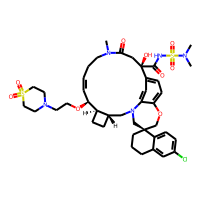
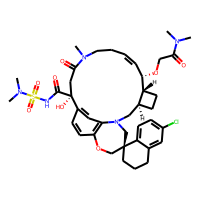
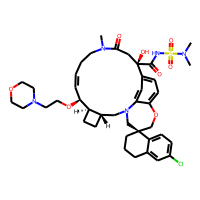
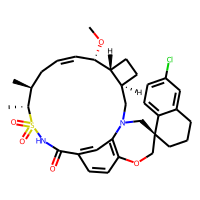

In [19]:
molecules = pd.DataFrame({"name": names, "smiles": smiles})
PandasTools.AddMoleculeColumnToFrame(molecules, "smiles")
molecules

In [20]:
molecules["molecular_weight"] = molecules["ROMol"].apply(Descriptors.ExactMolWt)
molecules["n_hba"] = molecules["ROMol"].apply(Descriptors.NumHAcceptors)
molecules["n_hbd"] = molecules["ROMol"].apply(Descriptors.NumHDonors)
molecules["logp"] = molecules["ROMol"].apply(Descriptors.MolLogP)
# Colors are used for plotting the molecules later
molecules["color"] = ["red", "green", "blue", "cyan"]
# NBVAL_CHECK_OUTPUT
molecules[["molecular_weight", "n_hba", "n_hbd", "logp"]]

,molecular_weight,n_hba,n_hbd,logp
0,861.320798,11,2,2.8735
1,785.322512,9,2,3.2313
2,813.353812,10,2,3.4753
3,612.242471,6,1,5.8984


,name,smiles,ROMol,molecular_weight,n_hba,n_hbd,logp,color
0,CHEMBL4580244,CN1CC/C=C/[C@H](OCCN2CCS(=O)(=O)CC2)[C@@H]2CC[...,,861.320798,11,2,2.8735,red
1,CHEMBL4535151,CN(C)C(=O)CO[C@H]1/C=C/CCN(C)C(=O)C[C@](O)(C(=...,,785.322512,9,2,3.2313,green
2,CHEMBL4553660,CN1CC/C=C/[C@H](OCCN2CCOCC2)[C@@H]2CC[C@H]2CN2...,,813.353812,10,2,3.4753,blue
3,CHEMBL4446378,CO[C@H]1/C=C/C[C@H](C)[C@@H](C)S(=O)(=O)NC(=O)...,,612.242471,6,1,5.8984,cyan

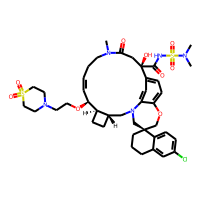
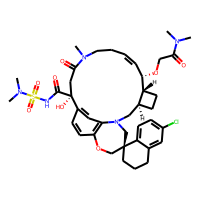
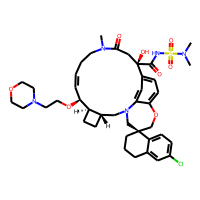
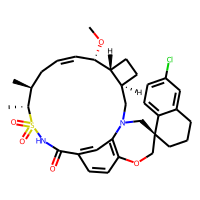

In [21]:
# Full preview
molecules

In [22]:
ro5_properties = {
    "molecular_weight": (500, "molecular weight (Da)"),
    "n_hba": (10, "# HBA"),
    "n_hbd": (5, "# HBD"),
    "logp": (5, "logP"),
}

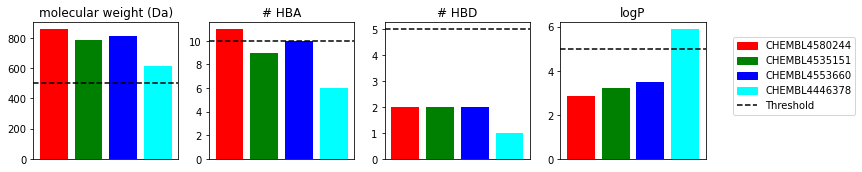

In [23]:
# Start 1x4 plot frame
fig, axes = plt.subplots(figsize=(10, 2.5), nrows=1, ncols=4)
x = np.arange(1, len(molecules) + 1)
colors = ["red", "green", "blue", "cyan"]

# Create subplots
for index, (key, (threshold, title)) in enumerate(ro5_properties.items()):
    axes[index].bar([1, 2, 3, 4], molecules[key], color=colors)
    axes[index].axhline(y=threshold, color="black", linestyle="dashed")
    axes[index].set_title(title)
    axes[index].set_xticks([])

# Add legend
legend_elements = [
    mpatches.Patch(color=row["color"], label=row["name"]) for index, row in molecules.iterrows()
]
legend_elements.append(Line2D([0], [0], color="black", ls="dashed", label="Threshold"))
fig.legend(handles=legend_elements, bbox_to_anchor=(1.2, 0.8))

# Fit subplots and legend into figure
plt.tight_layout()
plt.show()

### Define a function "calculate_ro5_properties" to investigate for each compound whether it violates the Ro5

In [24]:
def calculate_ro5_properties(smiles):
    """
    Test if input molecule (SMILES) fulfills Lipinski's rule of five.

    Parameters
    ----------
    smiles : str
        SMILES for a molecule.

    Returns
    -------
    pandas.Series
        Molecular weight, number of hydrogen bond acceptors/donor and logP value
        and Lipinski's rule of five compliance for input molecule.
    """
    # RDKit molecule from SMILES
    molecule = Chem.MolFromSmiles(smiles)
    # Calculate Ro5-relevant chemical properties
    molecular_weight = Descriptors.ExactMolWt(molecule)
    n_hba = Descriptors.NumHAcceptors(molecule)
    n_hbd = Descriptors.NumHDonors(molecule)
    logp = Descriptors.MolLogP(molecule)
    # Check if Ro5 conditions fulfilled
    conditions = [molecular_weight <= 500, n_hba <= 10, n_hbd <= 5, logp <= 5]
    ro5_fulfilled = sum(conditions) >= 3
    # Return True if no more than one out of four conditions is violated
    return pd.Series(
        [molecular_weight, n_hba, n_hbd, logp, ro5_fulfilled],
        index=["molecular_weight", "n_hba", "n_hbd", "logp", "ro5_fulfilled"],
    )

In [25]:
for name, smiles in zip(molecules["name"], molecules["smiles"]):
    print(f"Ro5 fulfilled for {name}: {calculate_ro5_properties(smiles)['ro5_fulfilled']}")

Ro5 fulfilled for CHEMBL4580244: False
Ro5 fulfilled for CHEMBL4535151: True
Ro5 fulfilled for CHEMBL4553660: True
Ro5 fulfilled for CHEMBL4446378: False


### Apply Ro5 to the MCL1 dataset

In [26]:
molecules = pd.read_csv(HERE / "../T000_template/data/MCL_compounds.csv", index_col=0)
print(molecules.shape)

ro5_properties = molecules["smiles"].apply(calculate_ro5_properties)
ro5_properties.head()

(553, 6)


,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,785.322512,9,2,3.2313,True
1,861.320798,11,2,2.8735,False
2,813.353812,10,2,3.4753,True
3,837.334969,10,4,3.3603,True
4,819.324404,9,2,4.0940,True


,molecule_chembl_id,IC50,units,smiles,pIC50,ROMol,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,CHEMBL4535151,0.2,nM,CN(C)C(=O)CO[C@H]1/C=C/CCN(C)C(=O)C[C@](O)(C(=...,9.698970,,785.322512,9,2,3.2313,True
1,CHEMBL4580244,0.2,nM,CN1CC/C=C/[C@H](OCCN2CCS(=O)(=O)CC2)[C@@H]2CC[...,9.698970,,861.320798,11,2,2.8735,False
2,CHEMBL4553660,0.2,nM,CN1CC/C=C/[C@H](OCCN2CCOCC2)[C@@H]2CC[C@H]2CN2...,9.698970,,813.353812,10,2,3.4753,True
3,CHEMBL4464768,0.3,nM,CN1CC/C=C/[C@H](OCCNCC(F)(F)CO)[C@@H]2CC[C@H]2...,9.522879,,837.334969,10,4,3.3603,True
4,CHEMBL4446369,0.3,nM,CN1CC/C=C/[C@H](OCCN2CC(F)(F)C2)[C@@H]2CC[C@H]...,9.522879,,819.324404,9,2,4.0940,True

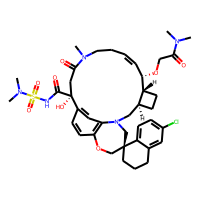
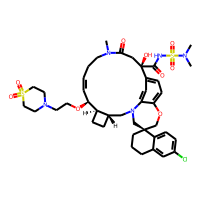
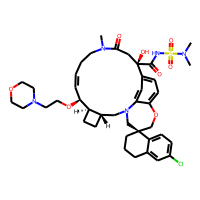
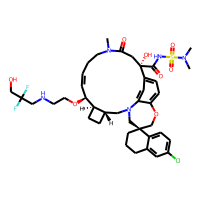
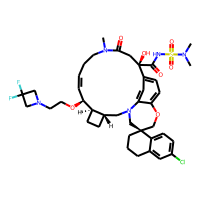

In [27]:
#Concatenate molecules with Ro5 data.
molecules = pd.concat([molecules, ro5_properties], axis=1)
molecules.head()

In [28]:
# The column "ro5_fulfilled" contains boolean values and use the column values directly to subset data
molecules_ro5_fulfilled = molecules[molecules["ro5_fulfilled"]]
molecules_ro5_violated = molecules[~molecules["ro5_fulfilled"]]

print(f"# compounds in unfiltered data set: {molecules.shape[0]}")
print(f"# compounds in filtered data set: {molecules_ro5_fulfilled.shape[0]}")
print(f"# compounds not compliant with the Ro5: {molecules_ro5_violated.shape[0]}")

# compounds in unfiltered data set: 553
# compounds in filtered data set: 416
# compounds not compliant with the Ro5: 137


,molecule_chembl_id,IC50,units,smiles,pIC50,ROMol,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,CHEMBL4535151,0.2,nM,CN(C)C(=O)CO[C@H]1/C=C/CCN(C)C(=O)C[C@](O)(C(=...,9.698970,,785.322512,9,2,3.2313,True
2,CHEMBL4553660,0.2,nM,CN1CC/C=C/[C@H](OCCN2CCOCC2)[C@@H]2CC[C@H]2CN2...,9.698970,,813.353812,10,2,3.4753,True
3,CHEMBL4464768,0.3,nM,CN1CC/C=C/[C@H](OCCNCC(F)(F)CO)[C@@H]2CC[C@H]2...,9.522879,,837.334969,10,4,3.3603,True
4,CHEMBL4446369,0.3,nM,CN1CC/C=C/[C@H](OCCN2CC(F)(F)C2)[C@@H]2CC[C@H]...,9.522879,,819.324404,9,2,4.0940,True
6,CHEMBL4539543,0.3,nM,COC1CN(CCO[C@H]2/C=C/CCN(C)C(=O)C[C@](O)(C(=O)...,9.522879,,813.353812,10,2,3.4737,True

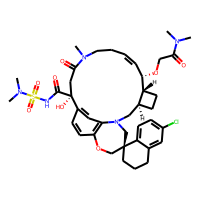
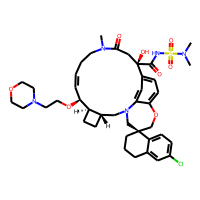
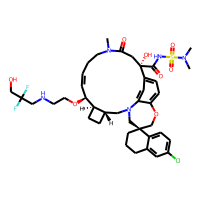
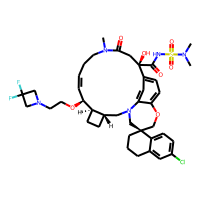
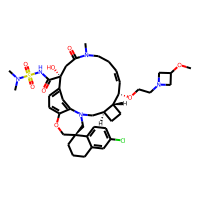

In [29]:
# Save filtered data
molecules_ro5_fulfilled.to_csv(DATA / "MCL1_compounds_lipinski.csv")
molecules_ro5_fulfilled.head()

### Visualize Ro5 properties (radar plot) 

In [30]:
# Define a function 'calculate_mean_std'to calculate statistics on Ro5 properties
def calculate_mean_std(dataframe):
    """
    Calculate the mean and standard deviation of a dataset.

    Parameters
    ----------
    dataframe : pd.DataFrame
        Properties (columns) for a set of items (rows).

    Returns
    -------
    pd.DataFrame
        Mean and standard deviation (columns) for different properties (rows).
    """
    # Generate descriptive statistics for property columns
    stats = dataframe.describe()
    # Transpose DataFrame (statistical measures = columns)
    stats = stats.T
    # Select mean and standard deviation
    stats = stats[["mean", "std"]]
    return stats

molecules_ro5_fulfilled_stats = calculate_mean_std(
    molecules_ro5_fulfilled[["molecular_weight", "n_hba", "n_hbd", "logp"]]
)
molecules_ro5_fulfilled_stats

,mean,std
molecular_weight,405.329341,125.117625
n_hba,5.012019,1.790833
n_hbd,1.814904,1.051388
logp,4.092377,1.611395


In [31]:
# Calculate the statistic for the dataset of compounds that are violating the Ro5.
molecules_ro5_violated_stats = calculate_mean_std(
    molecules_ro5_violated[["molecular_weight", "n_hba", "n_hbd", "logp"]]
)
molecules_ro5_violated_stats

,mean,std
molecular_weight,798.408916,512.720450
n_hba,9.525547,7.063869
n_hbd,6.489051,9.436410
logp,5.253057,4.282868


In [32]:
# Define a function '_scale_by_thresholds' to perform such scaling and will be used later during radar plotting.
def _scale_by_thresholds(stats, thresholds, scaled_threshold):
    """
    Scale values for different properties that have each an individually defined threshold.

    Parameters
    ----------
    stats : pd.DataFrame
        Dataframe with "mean" and "std" (columns) for each physicochemical property (rows).
    thresholds : dict of str: int
        Thresholds defined for each property.
    scaled_threshold : int or float
        Scaled thresholds across all properties.

    Returns
    -------
    pd.DataFrame
        DataFrame with scaled means and standard deviations for each physiochemical property.
    """
    # Raise error if scaling keys and data_stats indicies are not matching
    for property_name in stats.index:
        if property_name not in thresholds.keys():
            raise KeyError(f"Add property '{property_name}' to scaling variable.")
    # Scale property data
    stats_scaled = stats.apply(lambda x: x / thresholds[x.name] * scaled_threshold, axis=1)
    return stats_scaled

def _define_radial_axes_angles(n_axes):
    """Define angles (radians) for radial (x-)axes depending on the number of axes."""
    x_angles = [i / float(n_axes) * 2 * math.pi for i in range(n_axes)]
    x_angles += x_angles[:1]
    return x_angles

In [33]:
# Define a function 'plot_radar' to visualize the compounds' chemical properties in the form of a radar chart
def plot_radar(
    y,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max=None,
    output_path=None,
):
    """
    Plot a radar chart based on the mean and standard deviation of a data set's properties.

    Parameters
    ----------
    y : pd.DataFrame
        Dataframe with "mean" and "std" (columns) for each physicochemical property (rows).
    thresholds : dict of str: int
        Thresholds defined for each property.
    scaled_threshold : int or float
        Scaled thresholds across all properties.
    properties_labels : list of str
        List of property names to be used as labels in the plot.
    y_max : None or int or float
        Set maximum y value. If None, let matplotlib decide.
    output_path : None or pathlib.Path
        If not None, save plot to file.
    """

    # Define radial x-axes angles -- uses our helper function!
    x = _define_radial_axes_angles(len(y))
    # Scale y-axis values with respect to a defined threshold -- uses our helper function!
    y = _scale_by_thresholds(y, thresholds, scaled_threshold)
    # Since our chart will be circular we append the first value of each property to the end
    y = y.append(y.iloc[0])

    # Set figure and subplot axis
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)

    # Plot data
    ax.fill(x, [scaled_threshold] * 5, "cornflowerblue", alpha=0.2)
    ax.plot(x, y["mean"], "b", lw=3, ls="-")
    ax.plot(x, y["mean"] + y["std"], "orange", lw=2, ls="--")
    ax.plot(x, y["mean"] - y["std"], "orange", lw=2, ls="-.")

    # From here on, we only do plot cosmetics
    # Set 0Ã‚Â° to 12 o'clock
    ax.set_theta_offset(math.pi / 2)
    # Set clockwise rotation
    ax.set_theta_direction(-1)

    # Set y-labels next to 180Ã‚Â° radius axis
    ax.set_rlabel_position(180)
    # Set number of radial axes' ticks and remove labels
    plt.xticks(x, [])
    # Get maximal y-ticks value
    if not y_max:
        y_max = int(ax.get_yticks()[-1])
    # Set axes limits
    plt.ylim(0, y_max)
    # Set number and labels of y axis ticks
    plt.yticks(
        range(1, y_max),
        ["5" if i == scaled_threshold else "" for i in range(1, y_max)],
        fontsize=16,
    )

    # Draw ytick labels to make sure they fit properly
    # Note that we use [:1] to exclude the last element which equals the first element (not needed here)
    for i, (angle, label) in enumerate(zip(x[:-1], properties_labels)):
        if angle == 0:
            ha = "center"
        elif 0 < angle < math.pi:
            ha = "left"
        elif angle == math.pi:
            ha = "center"
        else:
            ha = "right"
        ax.text(
            x=angle,
            y=y_max + 1,
            s=label,
            size=16,
            horizontalalignment=ha,
            verticalalignment="center",
        )

    # Add legend relative to top-left plot
    labels = ("mean", "mean + std", "mean - std", "rule of five area")
    ax.legend(labels, loc=(1.1, 0.7), labelspacing=0.3, fontsize=16)

    # Save plot - use bbox_inches to include text boxes
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches="tight", transparent=True)

    plt.show()

In [34]:
# Define input parameters that should stay the same for both radar charts:
thresholds = {"molecular_weight": 500, "n_hba": 10, "n_hbd": 5, "logp": 5}
scaled_threshold = 5
properties_labels = [
    "Molecular weight (Da) / 100",
    "# HBA / 2",
    "# HBD",
    "LogP",
]
y_max = 8

/tmp/ipykernel_193/2078370473.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y = y.append(y.iloc[0])


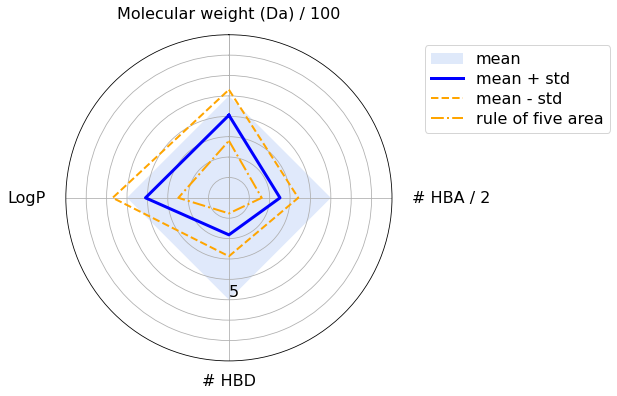

In [35]:
# Plot the radarplot for the dataset of compounds that fulfill the Ro5.
plot_radar(
    molecules_ro5_fulfilled_stats,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max,
)

/tmp/ipykernel_193/2078370473.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y = y.append(y.iloc[0])


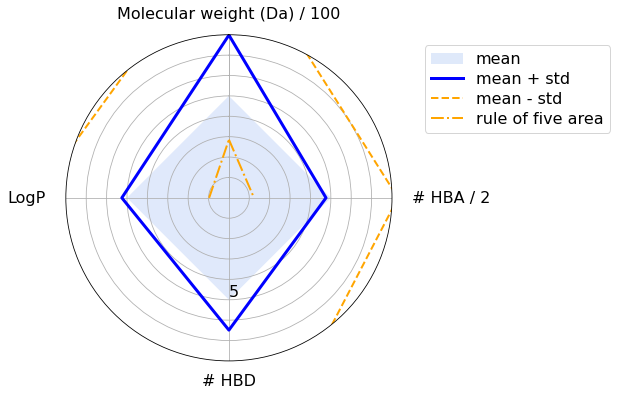

In [36]:
# Plot the radarplot for the dataset of compounds that violate the Ro5.
plot_radar(
    molecules_ro5_violated_stats,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max,
)